In [8]:
!pip install umap-learn[plot]

In [9]:
import math
import time
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet, Ridge
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score, roc_auc_score

# Alex modification: this requires GPU, which isn't needed for this notebook and fails without a GPU


# IPython imports
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import umap.umap_ as umap
import umap.plot

In [10]:
def stratify_and_project_latent_space(stratify_column, stratify_thresh, stratify_std, 
                                      latent_cols, latent_df, 
                                      normalize=False, train_ratio=1.0):
    if train_ratio == 1.0:
        train = latent_df
        test = latent_df
    else:
        train = latent_df.sample(frac=train_ratio)
        test = latent_df.drop(train.index)        
    hit = train.loc[train[stratify_column] >= stratify_thresh+(1*stratify_std)]
    miss = train.loc[train[stratify_column] < stratify_thresh-(1*stratify_std)]
    hit_np = hit[latent_cols].to_numpy()
    miss_np = miss[latent_cols].to_numpy()
    miss_mean_vector = np.mean(miss_np, axis=0)
    hit_mean_vector = np.mean(hit_np, axis=0)
    angle = angle_between(miss_mean_vector, hit_mean_vector)
        
    hit_test = test.loc[test[stratify_column] >= stratify_thresh+(1*stratify_std)]
    miss_test = test.loc[test[stratify_column] < stratify_thresh-(1*stratify_std)]
    
    if normalize:
        phenotype_vector = unit_vector(hit_mean_vector-miss_mean_vector)
        hit_dots = [np.dot(phenotype_vector, unit_vector(v)) for v in hit_test[latent_cols].to_numpy()]
        miss_dots = [np.dot(phenotype_vector, unit_vector(v)) for v in miss_test[latent_cols].to_numpy()]
    else:
        phenotype_vector = hit_mean_vector-miss_mean_vector
        hit_dots = [np.dot(phenotype_vector, v) for v in hit_test[latent_cols].to_numpy()]
        miss_dots = [np.dot(phenotype_vector, v) for v in miss_test[latent_cols].to_numpy()]
    t2, p2 = stats.ttest_ind(hit_dots, miss_dots, equal_var = False)
    
    return {f'{stratify_column}': (t2, p2, len(hit)) }

def merge_phecode_file(latent_df, phecode_file, phecode_name):
    df = pd.read_csv(phecode_file, sep='\t')
    df = df.rename(columns={"has_disease": phecode_name})
    new_df = pd.merge(latent_df, df, left_on='fpath', right_on='sample_id', how='inner')
    print(f' Phecode: {phecode_name} value counts: {new_df[phecode_name].value_counts()}')
    return new_df

def merge_prs_file(latent_df, phecode_file):
    df = pd.read_csv(phecode_file, sep='\t')
    new_df = pd.merge(latent_df, df, left_on='fpath', right_on='IID', how='inner')
    return new_df

    
def plot_nested_dictionary(all_scores):
    n = 4
    eps = 1e-300
    for model in all_scores:
        n = max(n, len(all_scores[model]))
    cols = max(2, int(math.ceil(math.sqrt(n))))
    rows = max(2, int(math.ceil(n / cols)))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3), sharex=True, dpi=300)
    renest = defaultdict(dict)
    errors = defaultdict(dict)
    lens = {}
    max_tstat = 0
    max_pval = 0
    for model in all_scores:
        for metric in all_scores[model]:
            renest[metric][model] = all_scores[model][metric][0]
            errors[metric][model] = all_scores[model][metric][1]
            lens[metric] = all_scores[model][metric][2]
            max_tstat = max(abs(all_scores[model][metric][0]), max_tstat)
            max_pval = max(-np.log10(all_scores[model][metric][1]+eps), max_pval)
    for metric, ax in zip(renest, axes.ravel()):
         
        models = [k for k,v in sorted(renest[metric].items(), key=lambda x: x[0].lower())]
        tstats = [abs(v) for k,v in sorted(renest[metric].items(), key=lambda x: x[0].lower())]
        pvalues = [-np.log10(v) if v > 1e-4800 else 500 for k,v in sorted(errors[metric].items(), key=lambda x: x[0].lower())]
        y_pos = np.arange(len(models))
        x = np.linspace(0, 1, int(max_pval))
        plt.imshow(x[:, np.newaxis], cmap=cm.jet)
        cb = plt.colorbar(ax=ax, ticks=[0, 1.0])
        cb.set_label('Negative Log P-Value')
        cb.ax.set_yticklabels(['0', f'{max_pval:0.0f}'])
        ax.barh(y_pos, tstats, color=[cm.jet(p/max_pval) for p in pvalues], align='center')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(models)
        ax.invert_yaxis()  # labels read top-to-bottom
        ax.set_xlabel('T–Statistic')
        ax.xaxis.set_tick_params(which='both', labelbottom=True)
        ax.set_title(f'{metric}\n n={lens[metric]}')
            
    plt.tight_layout()    
    

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::
            angle_between((1, 0, 0), (0, 1, 0))
            90
            angle_between((1, 0, 0), (1, 0, 0))
            0.0
            angle_between((1, 0, 0), (-1, 0, 0))
            180
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)) * 180 / 3.141592

def get_phenotype_vector(stratify_column, stratify_thresh, stratify_std, latent_cols, latent_df):
    hit = latent_df.loc[latent_df[stratify_column] >= stratify_thresh+stratify_std][latent_cols].to_numpy()
    miss = latent_df.loc[latent_df[stratify_column] < stratify_thresh-stratify_std][latent_cols].to_numpy()
    miss_mean_vector = np.mean(miss, axis=0)
    hit_mean_vector = np.mean(hit, axis=0)
    angle = angle_between(miss_mean_vector, hit_mean_vector)
    return hit_mean_vector - miss_mean_vector

In [11]:
categorical_covariates = ['Sex_Male_0_0',
 'atrial_fibrillation_or_flutter',
 'coronary_artery_disease',
 'diabetes_type_2',
 'hypercholesterolemia',
 'hypertension',
 'Sinus_bradycardia',
 'Marked_sinus_bradycardia',
 'Other_sinus_rhythm']

continuous_covariates = ['age', 'bmi', 'RRInterval', 'QTInterval', 'LVM', 'RVEDV', 'PC1', 'PC2', 'PC3']

all_scores = defaultdict(dict)

In [12]:
continuous_covariates

['age', 'bmi', 'RRInterval', 'QTInterval', 'LVM', 'RVEDV', 'PC1', 'PC2', 'PC3']

In [13]:
col_rename = {f'22009_Genetic-principal-components_0_{i}': f'PC{i}' for i in range(1,41)}
#col_rename['fpath'] = 'sample_id'
col_rename['Genetic-sex_Male_0_0'] = 'sex'
col_rename['21003_Age-when-attended-assessment-centre_2_0'] = 'age'
col_rename['21001_Body-mass-index-BMI_2_0'] = 'bmi'

In [14]:
latent_file = "/home/anamika/ml4h/latent_data_test/latent_file.tsv"
latent_file_for_comparison = "/home/anamika/ml4h/latent_data_test/latent_file_for_comparison.tsv"
label_file = "/home/anamika/ml4h/latent_data_test/tensors_all_union.csv"

In [15]:
def latent_space_dataframe(infer_hidden_tsv, explore_csv):
    df = pd.read_csv(explore_csv)
    df['sample_id'] = pd.to_numeric(df['fpath'], errors='coerce')
    df2 = pd.read_csv(infer_hidden_tsv, sep='\t', engine='python')
    df2['sample_id'] = pd.to_numeric(df2['sample_id'], errors='coerce')
    latent_df = pd.merge(df, df2, on='sample_id', how='inner')
    return latent_df

latent_df = latent_space_dataframe(latent_file, label_file)
latent_df = latent_df.rename(columns=col_rename)
latent_dimension = 256
latent_cols = [f'latent_{i}' for i in range(latent_dimension)]
for c in categorical_covariates:
    all_scores['DropFuse ECG'].update(stratify_and_project_latent_space(c, 1, 0, latent_cols, latent_df))
for c in continuous_covariates:
    all_scores['DropFuse ECG'].update(stratify_and_project_latent_space(c, latent_df[c].median(), 
                                                                        0, latent_cols, latent_df))

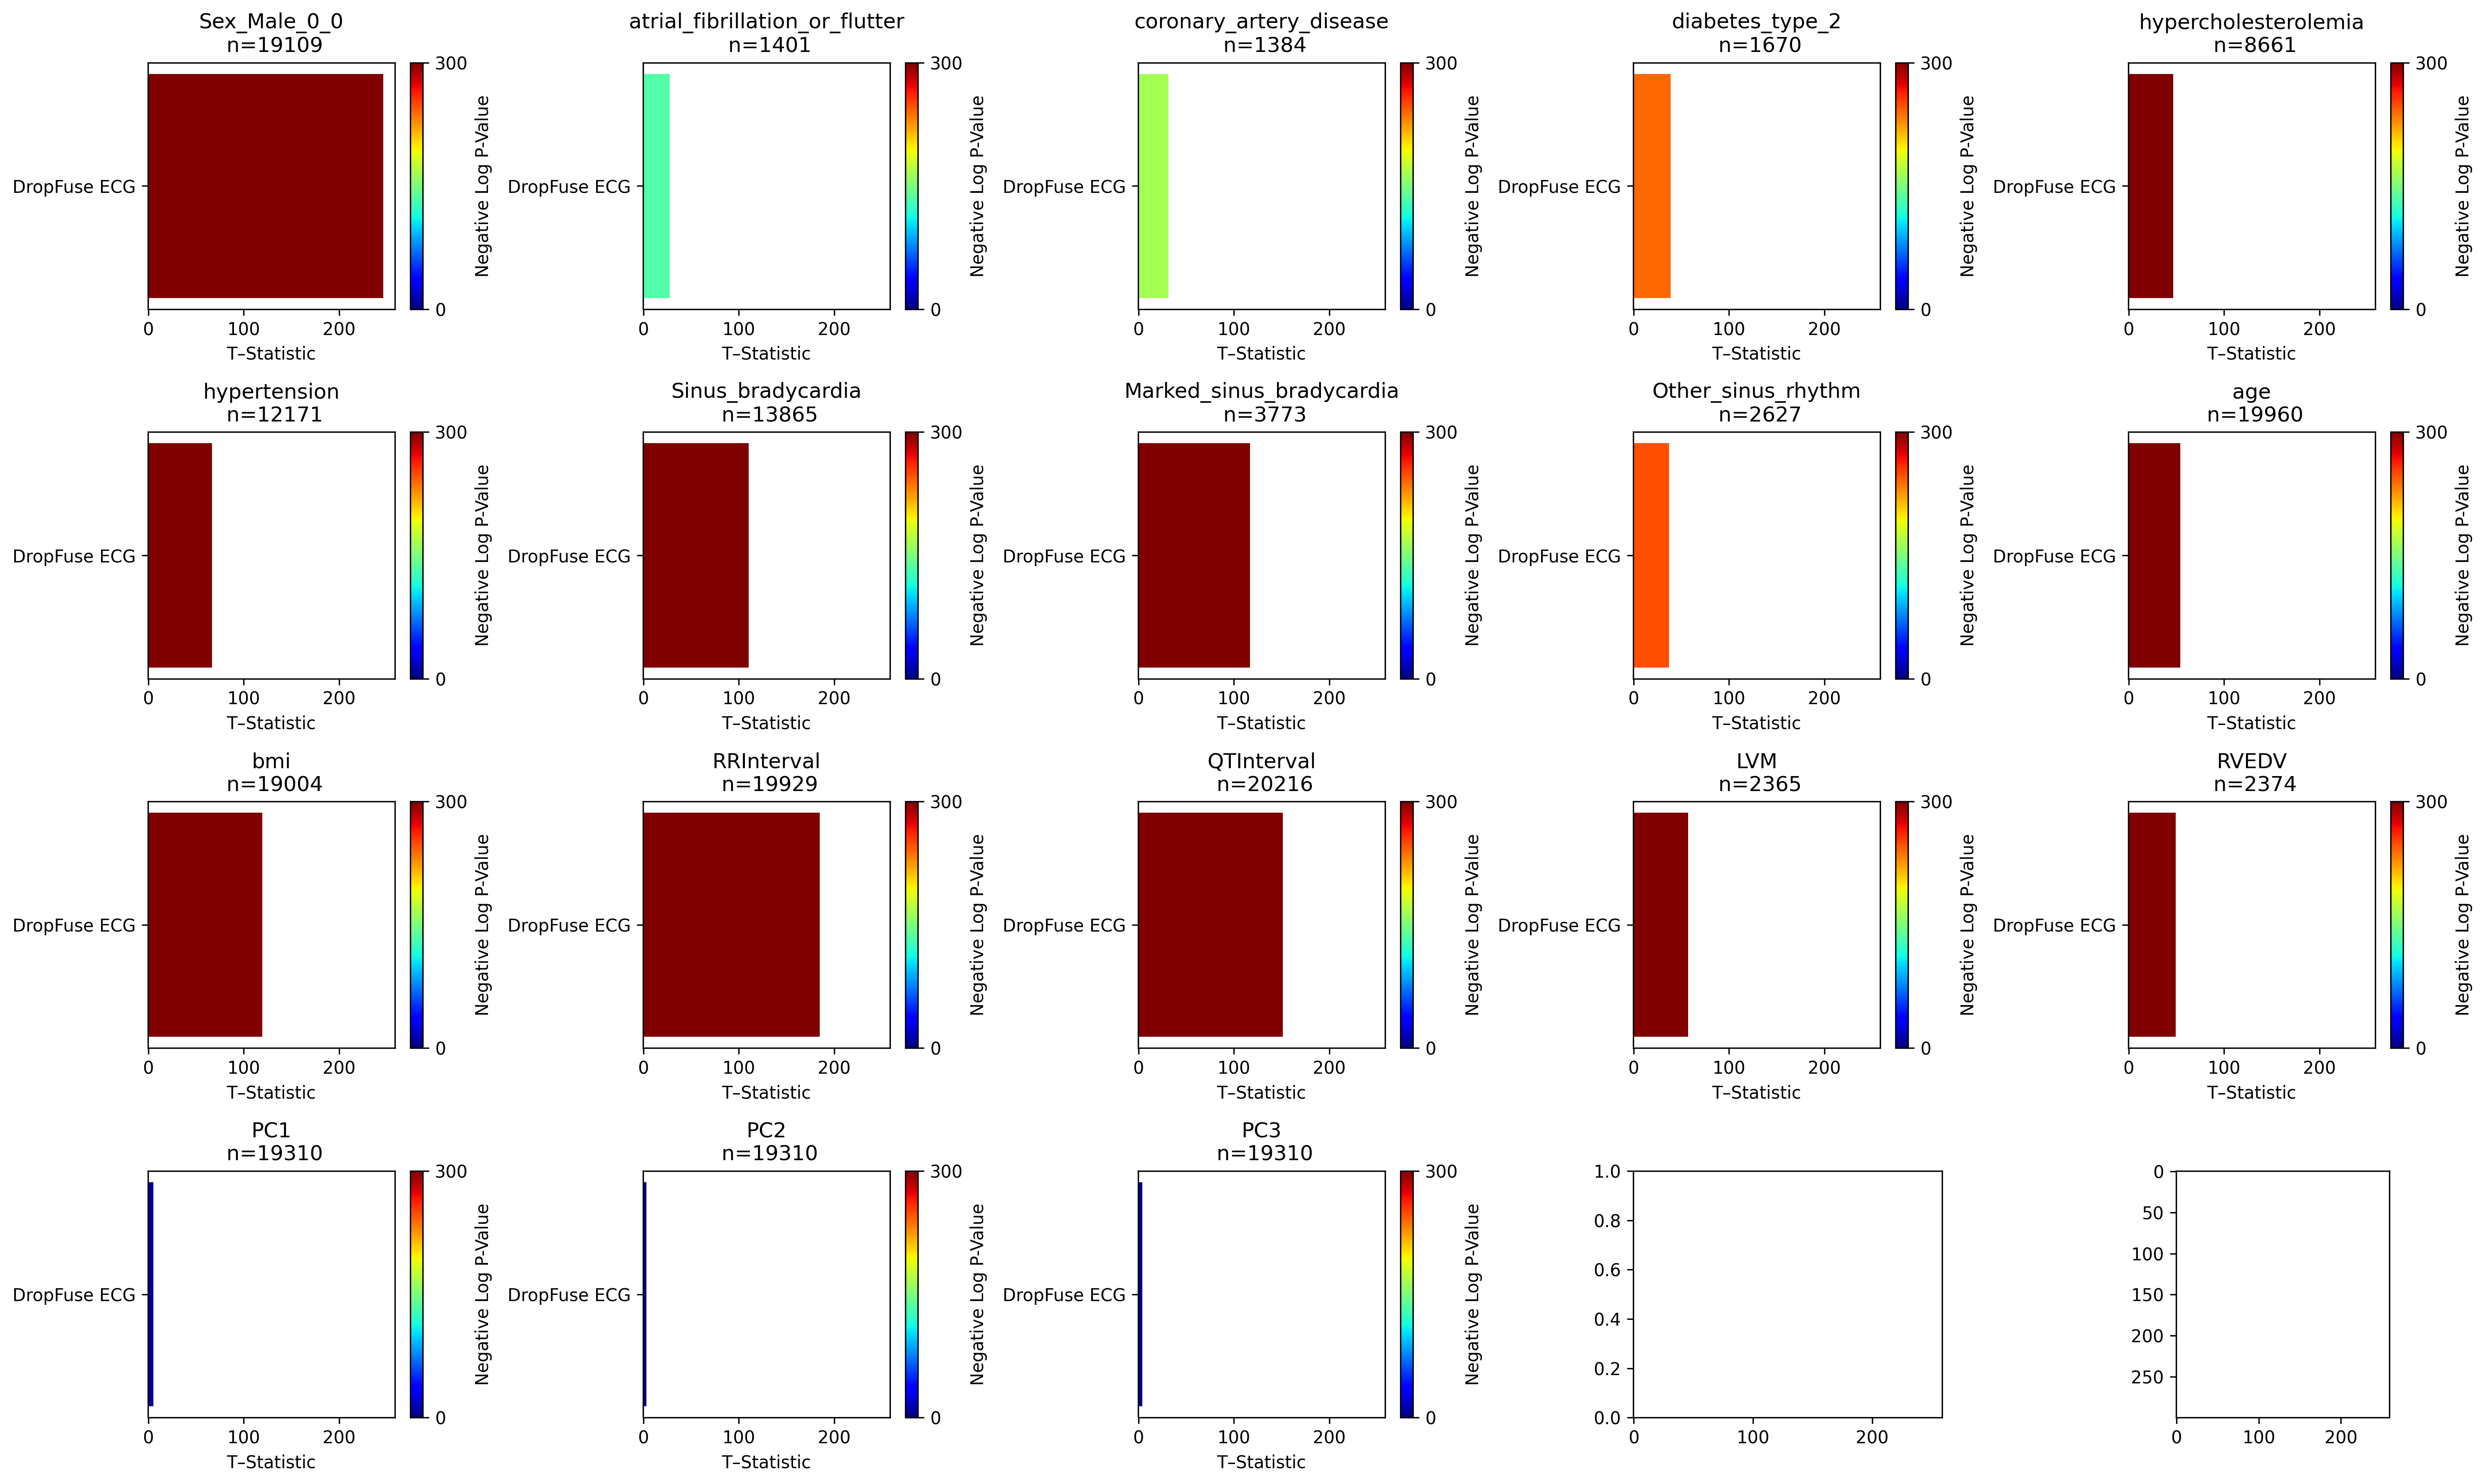

In [16]:
plot_nested_dictionary(all_scores)

## MRI

In [17]:
latent_df = latent_space_dataframe(latent_file_for_comparison, label_file)
latent_dimension = 256
latent_cols = [f'latent_{i}' for i in range(latent_dimension)]
latent_df = latent_df.rename(columns=col_rename)
for c in categorical_covariates:
    all_scores['DropFuse MRI'].update(stratify_and_project_latent_space(c, 1, 0, latent_cols, latent_df))
for c in continuous_covariates:
    all_scores['DropFuse MRI'].update(stratify_and_project_latent_space(c, latent_df[c].median(), 
                                                                        0, latent_cols, latent_df))


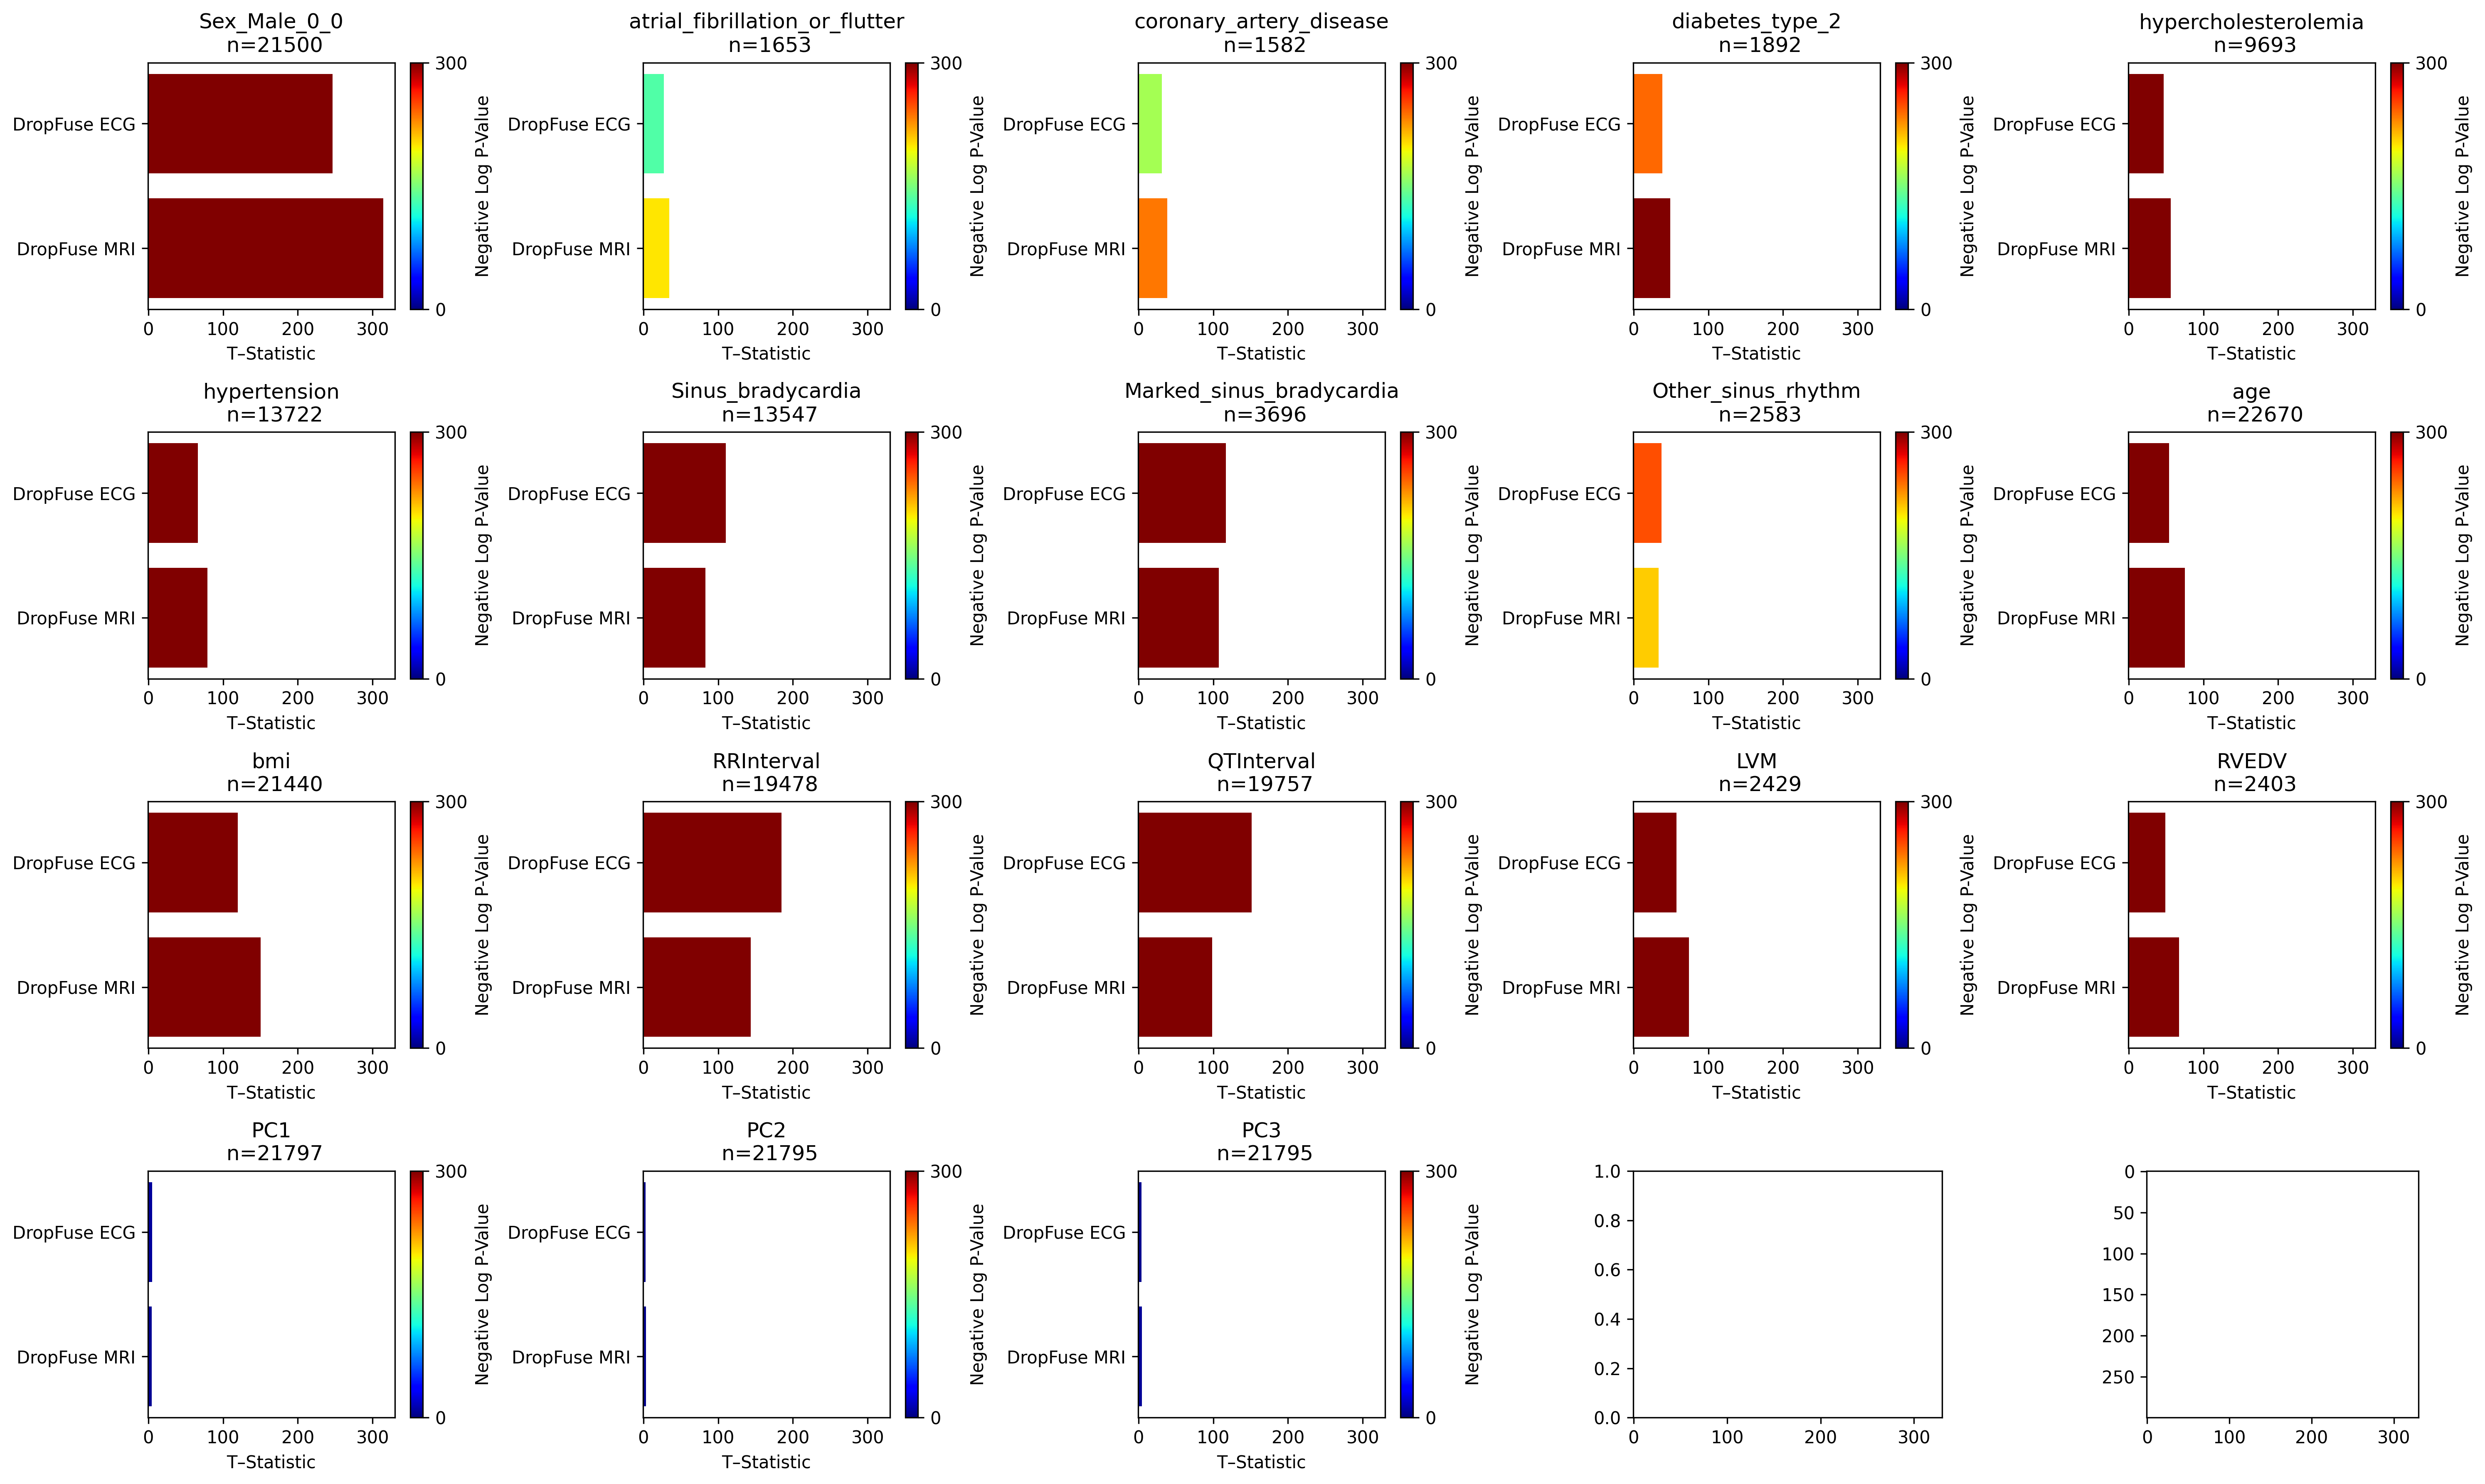

In [18]:
plot_nested_dictionary(all_scores)

In [19]:
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def confounder_vector(labels, space):
    clf = make_pipeline(StandardScaler(with_mean=True), Ridge(solver='lsqr'))
    clf.fit(space, labels)
    train_score = clf.score(space, labels)
    return clf[-1].coef_/clf[0].scale_, train_score


def confounder_matrix(adjust_cols, df, space):
    vectors = []
    scores = {}
    for col in adjust_cols:
        cv, r2 = confounder_vector(df[col], space)
        scores[col] = r2
        vectors.append(cv)
    return np.array(vectors), scores

def iterative_subspace_removal(adjust_cols, latent_df, latent_cols, r2_thresh=0.01, fit_pca=False): 
    new_cols = latent_cols
    new_adjust_cols = adjust_cols
    space = latent_df[latent_cols].to_numpy()

    if fit_pca:
        pca = PCA()
        pca.fit(space)
        space = pca.transform(space)
    
    iteration = 0
    while len(new_adjust_cols) > 0 and space.shape[-1] > len(new_adjust_cols):
        cfm, scores = confounder_matrix(new_adjust_cols, latent_df, space)
        u, s, vt = np.linalg.svd(cfm, full_matrices=True)
        nspace = np.matmul(space, vt[:, len(new_adjust_cols):])
        new_cols=[f'new_latent_{iteration}_{i}' for i in range(nspace.shape[-1])]
        df2 = pd.DataFrame(nspace, columns=new_cols, index=latent_df.index)
        latent_df = pd.concat([latent_df, df2], axis=1)
        
        iteration += 1
        space = nspace

        new_adjust_cols = [col for col, score in scores.items() if score > r2_thresh]
        keep_cols = new_cols + [c for c in latent_df.columns if 'latent' not in c]
        latent_df = latent_df[keep_cols]
        r_scores= {k:round(v,4) for k,v in scores.items()}
        print(f'Scores were {r_scores}, remaining columns are {new_adjust_cols}')
        print(f'After iteration {iteration} Space shape is: {space.shape}')
    return new_cols, latent_df

In [20]:

space = latent_df[latent_cols].to_numpy()
umapped = umap.UMAP().fit_transform(space)
umapped.shape

(44643, 2)

In [21]:
latent_df['Sex_Male_0_0'].to_numpy().shape


(44643,)

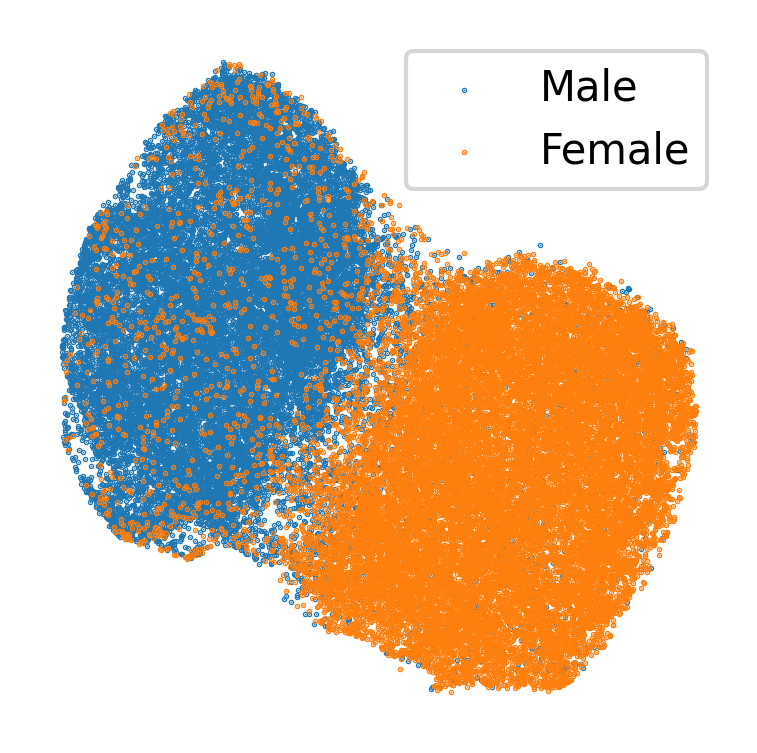

In [22]:
fig, ax = plt.subplots(figsize=(3,3), dpi=300)
ax.scatter(umapped[latent_df['Sex_Male_0_0'].to_numpy()==1,0], 
           umapped[latent_df['Sex_Male_0_0'].to_numpy()==1,1], s=.1, label='Male')
ax.scatter(umapped[latent_df['Sex_Male_0_0'].to_numpy()==0,0], 
           umapped[latent_df['Sex_Male_0_0'].to_numpy()==0,1], s=.1, label='Female')
ax.axis("off")
ax.legend()

In [23]:
r2_thresh = 0.01
adjust_cols = ['Sex_Male_0_0']
new_cols, latent_df = iterative_subspace_removal(adjust_cols, latent_df, latent_cols, r2_thresh=r2_thresh)

Scores were {'Sex_Male_0_0': 0.7758}, remaining columns are ['Sex_Male_0_0']
After iteration 1 Space shape is: (44643, 255)
Scores were {'Sex_Male_0_0': 0.7755}, remaining columns are ['Sex_Male_0_0']
After iteration 2 Space shape is: (44643, 254)
Scores were {'Sex_Male_0_0': 0.7747}, remaining columns are ['Sex_Male_0_0']
After iteration 3 Space shape is: (44643, 253)
Scores were {'Sex_Male_0_0': 0.774}, remaining columns are ['Sex_Male_0_0']
After iteration 4 Space shape is: (44643, 252)
Scores were {'Sex_Male_0_0': 0.7736}, remaining columns are ['Sex_Male_0_0']
After iteration 5 Space shape is: (44643, 251)
Scores were {'Sex_Male_0_0': 0.773}, remaining columns are ['Sex_Male_0_0']
After iteration 6 Space shape is: (44643, 250)
Scores were {'Sex_Male_0_0': 0.772}, remaining columns are ['Sex_Male_0_0']
After iteration 7 Space shape is: (44643, 249)
Scores were {'Sex_Male_0_0': 0.7718}, remaining columns are ['Sex_Male_0_0']
After iteration 8 Space shape is: (44643, 248)
Scores were

Scores were {'Sex_Male_0_0': 0.5985}, remaining columns are ['Sex_Male_0_0']
After iteration 67 Space shape is: (44643, 189)
Scores were {'Sex_Male_0_0': 0.5953}, remaining columns are ['Sex_Male_0_0']
After iteration 68 Space shape is: (44643, 188)
Scores were {'Sex_Male_0_0': 0.5785}, remaining columns are ['Sex_Male_0_0']
After iteration 69 Space shape is: (44643, 187)
Scores were {'Sex_Male_0_0': 0.5738}, remaining columns are ['Sex_Male_0_0']
After iteration 70 Space shape is: (44643, 186)
Scores were {'Sex_Male_0_0': 0.5672}, remaining columns are ['Sex_Male_0_0']
After iteration 71 Space shape is: (44643, 185)
Scores were {'Sex_Male_0_0': 0.5583}, remaining columns are ['Sex_Male_0_0']
After iteration 72 Space shape is: (44643, 184)
Scores were {'Sex_Male_0_0': 0.5413}, remaining columns are ['Sex_Male_0_0']
After iteration 73 Space shape is: (44643, 183)
Scores were {'Sex_Male_0_0': 0.5279}, remaining columns are ['Sex_Male_0_0']
After iteration 74 Space shape is: (44643, 182)


In [24]:
new_space = latent_df[new_cols].to_numpy()
umapped_debias = umap.UMAP().fit_transform(new_space)

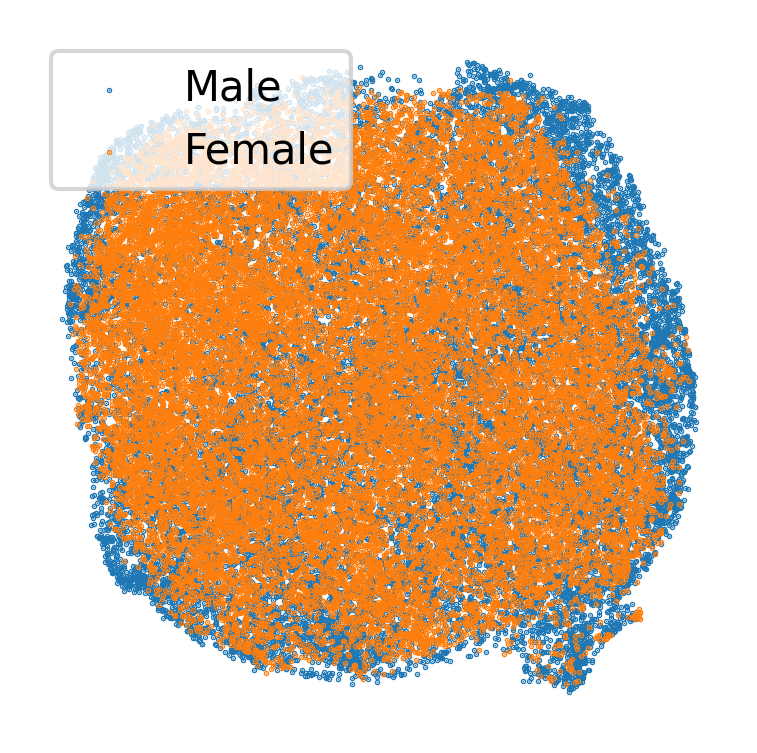

In [25]:
fig, ax = plt.subplots(figsize=(3,3), dpi=300)
ax.scatter(umapped_debias[latent_df['Sex_Male_0_0'].to_numpy()==1,0], 
           umapped_debias[latent_df['Sex_Male_0_0'].to_numpy()==1,1], s=.1, label='Male')
ax.scatter(umapped_debias[latent_df['Sex_Male_0_0'].to_numpy()==0,0], 
           umapped_debias[latent_df['Sex_Male_0_0'].to_numpy()==0,1], s=.1, label='Female')
ax.axis("off")
ax.legend()